In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import probplot
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#read in the raw data and immediately remove non balls in play to save memory.
from google.colab import drive
drive.mount('/drive')

raw23 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw19.csv')
raw19 = raw19.loc[raw19['type'] == 'X']

Mounted at /drive


In [4]:
#combine
all_data = pd.concat((raw23, raw22, raw21, raw20, raw19))

del raw22
del raw21
del raw20
del raw23
del raw19

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'])

#convert movement from feet to inches
all_data[['mx', 'mz']] = all_data[['pfx_x', 'pfx_z']].values * 12

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False, dtype = int)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR_bool'] = pit_hand['R']
all_data['bat_handR_bool'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define an upper limit on exit speed and flip it around so we can use the gamma distribution
all_data['ev2'] = all_data.launch_speed.max()+0.1 - all_data.launch_speed.values

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)
all_data['batter_id_hand_bool'] = all_data.batter.astype(str) + '-' + all_data.bat_handR_bool.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'batter_id_hand_bool',
                     'balls', 'strikes', 'game_year','inning', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                     'mx', 'mz', 'plate_x', 'plate_z',
                     'release_spin_rate', 'release_extension', 'pitcher',  'launch_speed', 'launch_angle', 'pit_handR',
                     'bat_handR','pit_handR_bool', 'bat_handR_bool',  'x', 'y', 'hit_direction', 'hd', 'ev2']]

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(all_data.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

train = all_data.merge(batter_indices, on = 'batter_id_hand')

In [5]:
all_data.launch_speed.max() + 0.1

122.5

In [15]:
#save the batter indices so we can match embedding index with batter when we actually optimize positioning
batter_indices.to_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/neural_net_batter_indices.csv', index=False)

### Hit Direction

In [16]:
features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'pit_handR', 'bat_handR', 'batter_index']

#z score variables
standardizer = StandardScaler().fit(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z']].values)
train[['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z']] = standardizer.transform(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z']].values)

In [17]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.hd.values
trainset = DataSet(train_x, train_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =128, shuffle = True)

In [18]:
#we fit a batter specific mixture of betas earlier, so our density network is going to output a mixture of betas
embedding_size = 15

class BMM(nn.Module):
    def __init__(self):
        super(BMM, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.l1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.l2 = nn.Linear(in_features = 128, out_features = 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64, 32)
        #output the weights for each beta dist
        self.weight_output = nn.Linear(32, 2)
        #output the alphas
        self.alpha_output = nn.Linear(32, 2)
        #output the betas
        self.beta_output = nn.Linear(32, 2)

        self.relu = nn.ReLU()

    def forward(self, x):

        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
        o = self.relu(self.l1(conc))
        o = self.relu(self.l2(o))
        o = self.relu(self.l3(o))
        o = self.relu(self.l4(o))

        #for the weights, I want to avoid mode collapse, so I'm going to estimate the log odds from the weights I found in my exploratory analysis (0.4 and 0.6) and just add my output to that.
        #the intial output should be close to 0 so we will start out with good numbers to begin with and train from there.
        #note the softmax of [log(0.4), log(0.6)] is 0.4,0.6 as desired, so we'll start there
        weights = nn.Softmax(dim = -1)(torch.log(torch.tensor([[0.4,0.6]]).to(device)) + self.weight_output(o))

        #similarly with alpha, I want to add to the alphas I had originally: 3 and 3. Note alphas have to be positive, so relu them and add 1, which means I'll actually add to 2 and 2 instead of 3 and 3
        alphas = self.relu(self.alpha_output(o) + torch.tensor([[2,2]]).to(device)) + 1

        #for betas I add to the original values of 9 and 2
        betas = self.relu(self.beta_output(o) + torch.tensor([[8,1]]).to(device)) + 1
        return weights, alphas, betas

In [19]:
#define the loss function: beta mixture model log likelihood
def beta_mixture_loss(weights, alphas, betas, target):
  dist1 = torch.distributions.beta.Beta(concentration1 = alphas[:,0],concentration0 = betas[:,0])
  dist2 = torch.distributions.beta.Beta(concentration1 = alphas[:,1], concentration0 = betas[:,1])
  _like = weights[:,0] * torch.exp(dist1.log_prob(target)) + weights[:,1] * torch.exp(dist2.log_prob(target))
  return -1*torch.mean(torch.log(_like))

In [21]:
#train
learning_rate = 1e-3
epochs = 25
model = BMM().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = beta_mixture_loss
train_losses = []

In [22]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        w,a,b = model(x)
        #calculate loss
        loss = loss_fn(w,a,b, y_truth)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))
    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = -0.105615
epoch : 2/25, loss = -0.129879
epoch : 3/25, loss = -0.154850
epoch : 4/25, loss = -0.166813
epoch : 5/25, loss = -0.170160
epoch : 6/25, loss = -0.172861
epoch : 7/25, loss = -0.176122
epoch : 8/25, loss = -0.180392
epoch : 9/25, loss = -0.183282
epoch : 10/25, loss = -0.184914
epoch : 11/25, loss = -0.185972
epoch : 12/25, loss = -0.186722
epoch : 13/25, loss = -0.187329
epoch : 14/25, loss = -0.187673
epoch : 15/25, loss = -0.188254
epoch : 16/25, loss = -0.188476
epoch : 17/25, loss = -0.188984
epoch : 18/25, loss = -0.189262
epoch : 19/25, loss = -0.189626
epoch : 20/25, loss = -0.189800
epoch : 21/25, loss = -0.190168
epoch : 22/25, loss = -0.190561
epoch : 23/25, loss = -0.190843
epoch : 24/25, loss = -0.191086
epoch : 25/25, loss = -0.191419


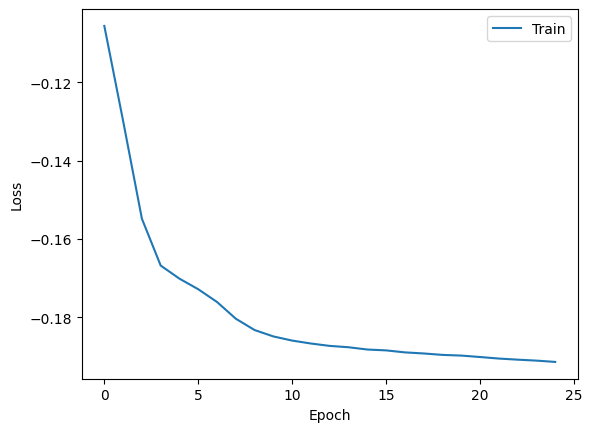

In [23]:
plt.plot(train_losses, label = 'Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

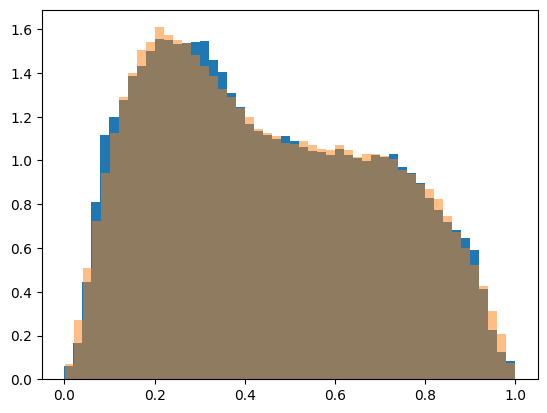

In [25]:
#sanity check
w,alphas,betas = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train[['w1','w2']] = w.detach().cpu().numpy()
train[['a1','a2']] = alphas.detach().cpu().numpy()
train[['b1','b2']] = betas.detach().cpu().numpy()
choice = np.random.binomial(1, train.w1.values, size = train.shape[0])
samp = choice * beta(a = train.a1.values, b = train.b1.values).rvs() + (1-choice) * beta(a = train.a2.values, b = train.b2.values).rvs()
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(samp, density = True, bins = 50, alpha = 0.5)
plt.show()

In [26]:
torch.save(model.state_dict(), '/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/hit_direction_net')

### Launch Angle

In [27]:
features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'pit_handR', 'bat_handR', 'batter_index']
standardizer = StandardScaler().fit(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction']].values)
train[['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z']] = standardizer.transform(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction']].values)

In [28]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.launch_angle.values
trainset = DataSet(train_x, train_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =128, shuffle = True)

In [29]:
embedding_size = 15

class LA(nn.Module):
  def __init__(self):
      super(LA, self).__init__()

      self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
      self.batter_embedding.weight.data.fill_(.1)
      self.l1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
      self.l2 = nn.Linear(in_features = 128, out_features = 128)
      self.l3 = nn.Linear(128, 64)
      self.l4 = nn.Linear(64, 32)
      self.relu = nn.ReLU()
      self.mean_layer1 = nn.Linear(32,1)
      self.std_layer1 = nn.Linear(32,1)

  def forward(self, x):
      batter_idx = x[:,-1].int()
      bat_emb = self.batter_embedding(batter_idx)

      conc = torch.cat((x[:,:-1], bat_emb), dim = -1)
      o = self.relu(self.l1(conc))
      o = self.relu(self.l2(o))
      o = self.relu(self.l3(o))
      o = self.relu(self.l4(o))

      #mean: add the output to the pymc mean
      mean = self.mean_layer1(o)
      #stddev
      stddev = self.relu(self.std_layer1(o)) + 1

      return mean, stddev

In [30]:
def gaussianloss(m, target, st):
  dist = torch.distributions.normal.Normal(loc = m.squeeze(1), scale = st.squeeze(1))
  return -1*torch.mean(dist.log_prob(target))

In [31]:
#train
learning_rate = 1e-3
epochs = 25
model = LA().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = gaussianloss
train_losses = []

In [32]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        mean, s = model(x)
        #calculate loss
        loss = loss_fn(mean, y_truth, s)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))
    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = 263.919057
epoch : 2/25, loss = 38.707706
epoch : 3/25, loss = 4.537495
epoch : 4/25, loss = 4.519482
epoch : 5/25, loss = 4.515092
epoch : 6/25, loss = 4.512895
epoch : 7/25, loss = 4.511249
epoch : 8/25, loss = 4.509795
epoch : 9/25, loss = 4.508477
epoch : 10/25, loss = 4.507212
epoch : 11/25, loss = 4.505924
epoch : 12/25, loss = 4.504653
epoch : 13/25, loss = 4.503413
epoch : 14/25, loss = 4.502231
epoch : 15/25, loss = 4.501163
epoch : 16/25, loss = 4.500234
epoch : 17/25, loss = 4.499512
epoch : 18/25, loss = 4.498847
epoch : 19/25, loss = 4.498311
epoch : 20/25, loss = 4.497807
epoch : 21/25, loss = 4.497350
epoch : 22/25, loss = 4.496958
epoch : 23/25, loss = 4.496579
epoch : 24/25, loss = 4.496224
epoch : 25/25, loss = 4.495838


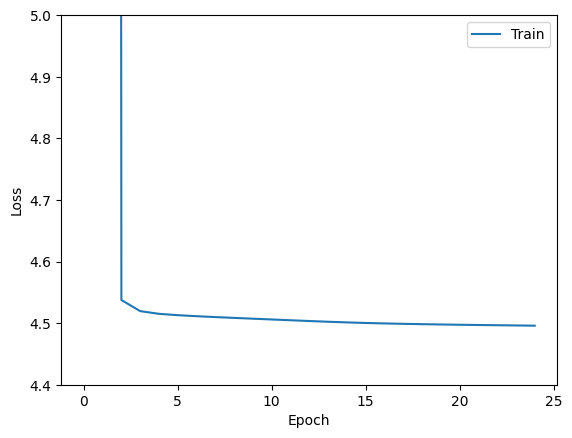

In [35]:
plt.plot(train_losses, label = 'Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim((4.4,5))
plt.show()

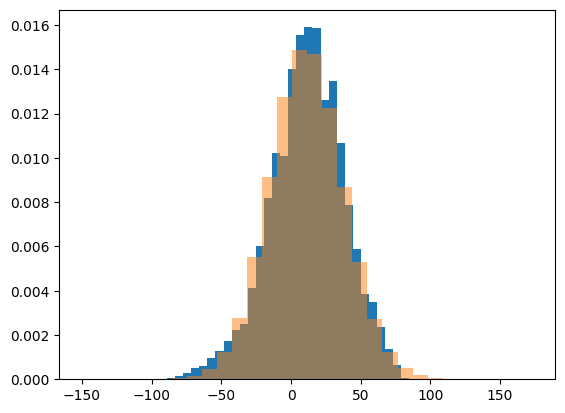

In [36]:
#sanity check
mu, var = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train['m'] = mu.detach().cpu().numpy()
train['s'] = var.detach().cpu().numpy()
samp = norm(loc = train.m.values, scale = train.s.values).rvs()
plt.hist(train.launch_angle.values, density = True, bins = 30)
plt.hist(samp, density = True, bins = 30, alpha = 0.5)
plt.show()

In [37]:
torch.save(model.state_dict(), '/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_angle_net')

### Exit Speed

In [38]:
features = ['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'launch_angle_z', 'pit_handR', 'bat_handR', 'batter_index']
standardizer = StandardScaler().fit(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle']].values)
train[['release_speed_z', 'mx_z', 'mz_z', 'plate_x_z', 'plate_z_z', 'hit_direction_z', 'launch_angle_z']] = standardizer.transform(train[['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle']].values)

In [39]:
#data set class
class DataSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

train_x = train[features].values
train_y = train.ev2.values
trainset = DataSet(train_x, train_y)

#data loaders
trainloader = DataLoader(trainset, batch_size =256, shuffle = True)

In [40]:
embedding_size = 15

class EV(nn.Module):
    def __init__(self):
        super(EV, self).__init__()

        self.batter_embedding = nn.Embedding(num_embeddings = batter_indices.shape[0], embedding_dim = embedding_size)
        self.batter_embedding.weight.data.fill_(.1)
        self.al1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.al3 = nn.Linear(128, 64)
        self.al4 = nn.Linear(64, 32)

        self.bl1 = nn.Linear(in_features = embedding_size + len(features) - 1, out_features = 128)
        self.bl3 = nn.Linear(128, 64)
        self.bl4 = nn.Linear(64, 32)

        self.relu = nn.ReLU()
        self.alpha_layer1 = nn.Linear(32,1)
        self.beta_layer1 = nn.Linear(32,1)

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.batter_embedding(batter_idx)

        conc = torch.cat((x[:,:-1], bat_emb), dim = -1).clone()
        o = self.relu(self.al1(conc))
        o = self.relu(self.al3(o))
        o = self.relu(self.al4(o))
        alpha = nn.ELU()(self.alpha_layer1(o)) + 1.

        v = self.relu(self.bl1(conc))
        v = self.relu(self.bl3(v))
        v = self.relu(self.bl4(v))
        beta = nn.ELU()(self.beta_layer1(v)) + 1.

        return alpha, beta

In [41]:
#gamma loss
def gamma_loss(alpha, beta, target):
    dist = torch.distributions.gamma.Gamma(concentration = alpha.squeeze(1), rate = beta.squeeze(1))

    _like = dist.log_prob(target)
    return -1*_like.mean()

In [42]:
learning_rate = 5e-4
epochs = 25
model = EV().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
loss_fn = gamma_loss
train_losses = []

In [43]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y_truth) in enumerate(trainloader):
        x = x.to(device)
        y_truth = y_truth.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        alpha, beta = model(x)
        #calculate loss
        loss = loss_fn(alpha, beta, y_truth)
        loss_val += loss.item()

        #backprop
        loss.backward()
        optimizer.step()

    train_losses.append(loss_val / len(trainloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

epoch : 1/25, loss = 4.146112
epoch : 2/25, loss = 3.782813
epoch : 3/25, loss = 3.735334
epoch : 4/25, loss = 3.709144
epoch : 5/25, loss = 3.692173
epoch : 6/25, loss = 3.678139
epoch : 7/25, loss = 3.663939
epoch : 8/25, loss = 3.653086
epoch : 9/25, loss = 3.645627
epoch : 10/25, loss = 3.639517
epoch : 11/25, loss = 3.634682
epoch : 12/25, loss = 3.629338
epoch : 13/25, loss = 3.624197
epoch : 14/25, loss = 3.619331
epoch : 15/25, loss = 3.614607
epoch : 16/25, loss = 3.610161
epoch : 17/25, loss = 3.606351
epoch : 18/25, loss = 3.603238
epoch : 19/25, loss = 3.600044
epoch : 20/25, loss = 3.597627
epoch : 21/25, loss = 3.595229
epoch : 22/25, loss = 3.592720
epoch : 23/25, loss = 3.590899
epoch : 24/25, loss = 3.588617
epoch : 25/25, loss = 3.586772


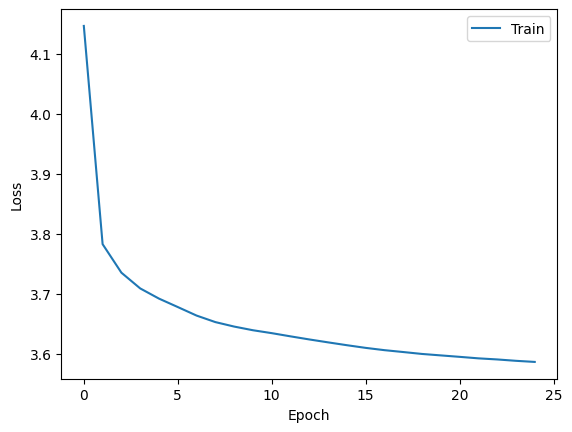

In [44]:
plt.plot(train_losses, label = 'Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

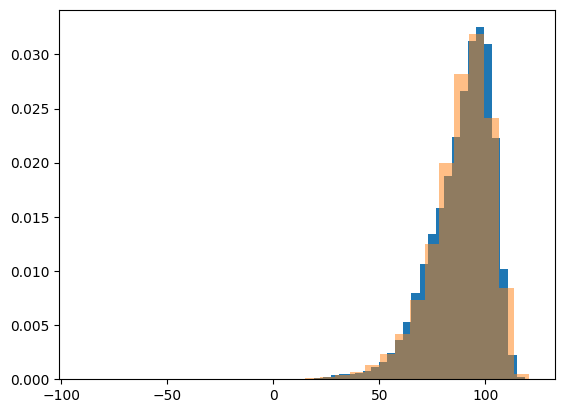

In [45]:
#sanity check
alpha, beta = model(torch.tensor(train[features].values, dtype = torch.float32).to(device))
train['alpha'] = alpha.detach().cpu().numpy()
train['beta'] = beta.detach().cpu().numpy()
samp = train.launch_speed.max() + 0.1 - gamma(a = train.alpha.values, scale = 1/train.beta.values).rvs()
plt.hist(train.launch_speed.values, density = True, bins = 30)
plt.hist(samp, density = True, bins = 30, alpha = 0.5)
plt.show()

In [46]:
torch.save(model.state_dict(), '/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/launch_speed_net')

In [47]:
#save the standardizer info as well
standardizer_info = pd.DataFrame(columns = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'hit_direction', 'launch_angle'], index = ['mean', 'scale'], data = np.vstack((standardizer.mean_, standardizer.scale_)))
standardizer_info.to_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/bip_distributions/standardizer_info.csv', index=False)

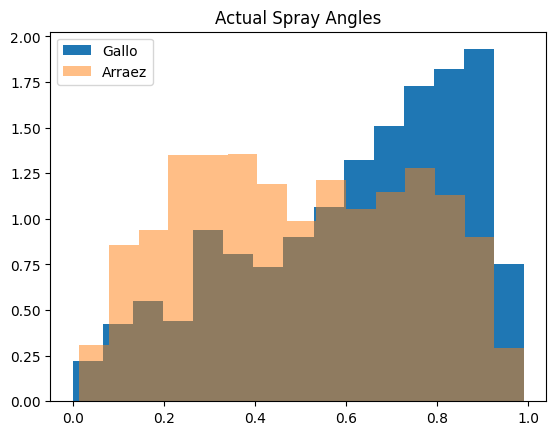

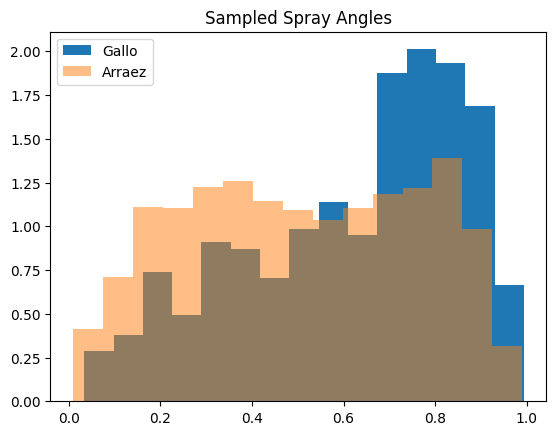

In [53]:
#last sanity check: compare Joey Gallo and Luis Arraez
gallo = train.loc[train.batter == 608336]
arraez = train.loc[train.batter == 650333]

#sample hit directions
from scipy.stats import beta
choice = np.random.binomial(1, gallo.w1.values, size = gallo.shape[0])
samp1 = choice * beta(a = gallo.a1.values, b = gallo.b1.values).rvs() + (1-choice) * beta(a = gallo.a2.values, b = gallo.b2.values).rvs()
choice = np.random.binomial(1, arraez.w1.values, size = arraez.shape[0])
samp2 = choice * beta(a = arraez.a1.values, b = arraez.b1.values).rvs() + (1-choice) * beta(a = arraez.a2.values, b = arraez.b2.values).rvs()

plt.hist(1-gallo.hd.values, density = True, bins = 15, label = 'Gallo')
plt.hist(1-arraez.hd.values, density = True, bins = 15, label = 'Arraez', alpha = 0.5)
plt.legend()
plt.title('Actual Spray Angles')
plt.show()

plt.hist(1-samp1, density = True, bins = 15, label = 'Gallo')
plt.hist(1-samp2, density = True, bins = 15, label = 'Arraez', alpha = 0.5)
plt.legend()
plt.title('Sampled Spray Angles')
plt.show()

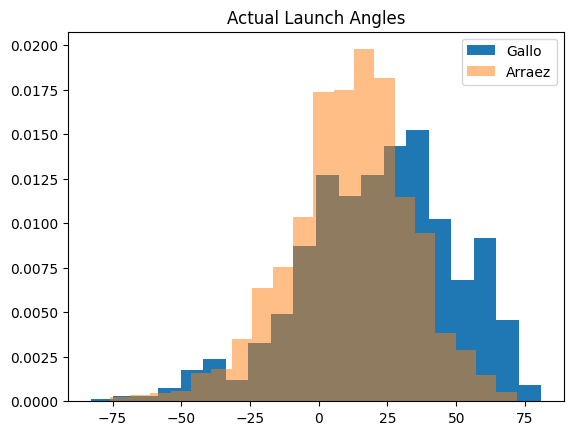

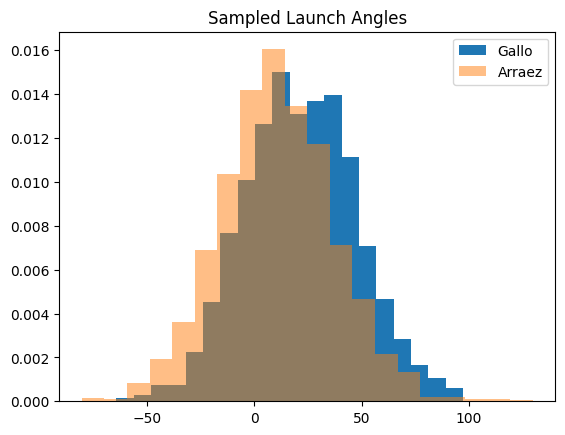

In [55]:
plt.hist(gallo.launch_angle.values, density = True, bins = 20, label = 'Gallo')
plt.hist(arraez.launch_angle.values, density = True, bins = 20, label = 'Arraez', alpha = 0.5)
plt.legend()
plt.title('Actual Launch Angles')
plt.show()

samp1 = norm(loc = gallo.m.values, scale = gallo.s.values).rvs()
samp2 = norm(loc = arraez.m.values, scale = arraez.s.values).rvs()
plt.hist(samp1, density = True, bins = 20, label = 'Gallo')
plt.hist(samp2, density = True, bins = 20, label = 'Arraez', alpha = 0.5)
plt.title('Sampled Launch Angles')
plt.legend()
plt.show()

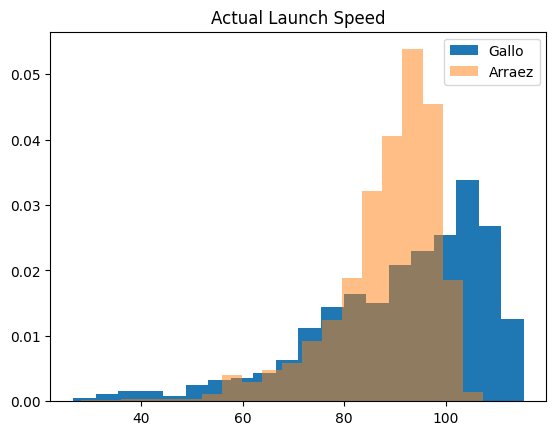

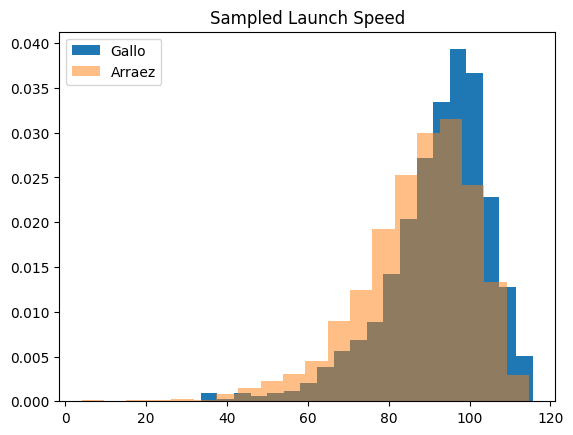

In [56]:
plt.hist(gallo.launch_speed.values, density = True, bins = 20, label = 'Gallo')
plt.hist(arraez.launch_speed.values, density = True, bins = 20, label = 'Arraez', alpha = 0.5)
plt.legend()
plt.title('Actual Launch Speed')
plt.show()

samp1 = train.launch_speed.max() + 0.1 - gamma(a = gallo.alpha.values, scale = 1/gallo.beta.values).rvs()
samp2 = train.launch_speed.max() + 0.1 - gamma(a = arraez.alpha.values, scale = 1/arraez.beta.values).rvs()
plt.hist(samp1, density = True, bins = 20, label = 'Gallo')
plt.hist(samp2, density = True, bins = 20, label = 'Arraez', alpha = 0.5)
plt.title('Sampled Launch Speed')
plt.legend()
plt.show()